In [1]:
import requests
import pandas as pd
import json
import ast
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [8]:
file_path="Resources/movies_metadata.csv"
movies_df=pd.read_csv(file_path)

cr_file_path="Resources\credit.csv"
credits_df=pd.read_csv(cr_file_path)

ratings_file_path="Resources/ratings.csv"
ratings_df=pd.read_csv(ratings_file_path)


<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\iffym\AppData\Local\Temp\ipykernel_2388\3735960652.py:4: SyntaxWarning: invalid escape sequence '\c'
  cr_file_path="Resources\credit.csv"
C:\Users\iffym\AppData\Local\Temp\ipykernel_2388\3735960652.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df=pd.read_csv(file_path)


In [9]:
#drop columns that are not needed

cleaned_movies_df= movies_df.drop(columns=["adult", "belongs_to_collection",
                "homepage","original_language",
                "overview","poster_path",
                "spoken_languages","title","tagline",
                "production_companies","production_countries",
                "video"])

#convert release date to datetime format
cleaned_movies_df["release_date"]=pd.to_datetime(cleaned_movies_df["release_date"], errors="coerce")
cleaned_movies_df["release_date"]=cleaned_movies_df["release_date"].dt.year

cleaned_movies_df=cleaned_movies_df.dropna() #drop rows with missing values
cleaned_movies_df=cleaned_movies_df.dropna(axis=1) #drop columns with missing values

#covert genres column from a list

cleaned_movies_df["genres"]=cleaned_movies_df["genres"].apply(lambda x:ast.literal_eval(x) if isinstance(x, str) else x)


In [10]:
# Fill NaN with empty lists
cleaned_movies_df["genres"] = cleaned_movies_df["genres"].apply(
    lambda x: x if isinstance(x, list) else []
)

cleaned_movies_df["genres"]=cleaned_movies_df["genres"].apply(lambda x: [i["name"] for i in x] if isinstance(x, list) else [])

cleaned_movies_df.head()


,budget,genres,id,imdb_id,original_title,popularity,release_date,revenue,runtime,status,vote_average,vote_count
0,30000000,"[Animation, Comedy, Family]",862,tt0114709,Toy Story,21.946943,1995.0,373554033.0,81.0,Released,7.7,5415.0
1,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,Jumanji,17.015539,1995.0,262797249.0,104.0,Released,6.9,2413.0
2,0,"[Romance, Comedy]",15602,tt0113228,Grumpier Old Men,11.7129,1995.0,0.0,101.0,Released,6.5,92.0
3,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,Waiting to Exhale,3.859495,1995.0,81452156.0,127.0,Released,6.1,34.0
4,0,[Comedy],11862,tt0113041,Father of the Bride Part II,8.387519,1995.0,76578911.0,106.0,Released,5.7,173.0


In [11]:
#filter movies released after 2015

last_decade_movies_df=cleaned_movies_df[(cleaned_movies_df["release_date"].notna()) & #removes NAN years/values
                                        (cleaned_movies_df["release_date"]>=2009) &
                                        (cleaned_movies_df["release_date"]<2020)] #filters movies released after 2010



# Flatten the 'genres' list and count occurrences
genre_counts = last_decade_movies_df['genres'].explode().value_counts()

# Create a DataFrame with the genre counts
genre_counts_df = pd.DataFrame(genre_counts).reset_index()
genre_counts_df.columns = ['genre', 'count']
genre_counts_df.head(20)


,genre,count
0,Drama,5854
1,Comedy,3970
2,Thriller,2703
3,Documentary,2087
4,Action,1856
5,Romance,1654
6,Horror,1554
7,Crime,1052
8,Science Fiction,920
9,Adventure,905


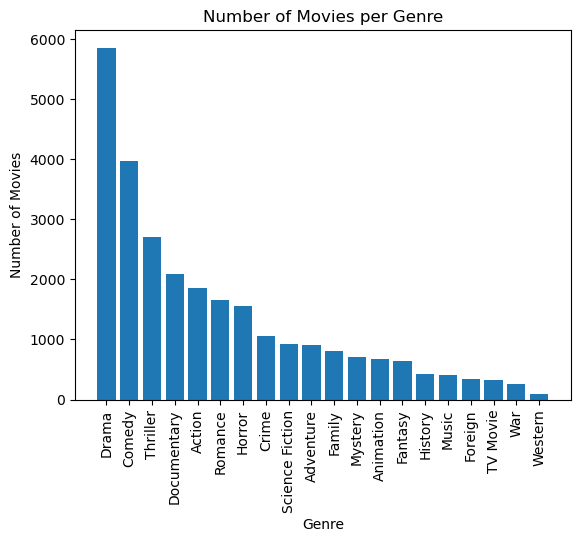

In [12]:
#number of movies per genre released over the years

plt.bar(genre_counts_df["genre"], genre_counts_df["count"])
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.title("Number of Movies per Genre")
plt.xticks(rotation=90)
plt.show()


In [13]:
final_movies=cleaned_movies_df[['id','original_title','vote_average', 'runtime']]
final_movies.head(20)


,id,original_title,vote_average,runtime
0,862,Toy Story,7.7,81.0
1,8844,Jumanji,6.9,104.0
2,15602,Grumpier Old Men,6.5,101.0
3,31357,Waiting to Exhale,6.1,127.0
4,11862,Father of the Bride Part II,5.7,106.0
5,949,Heat,7.7,170.0
6,11860,Sabrina,6.2,127.0
7,45325,Tom and Huck,5.4,97.0
8,9091,Sudden Death,5.5,106.0
9,710,GoldenEye,6.6,130.0


In [14]:
#create a dataframe of the top 10 genres per year released

#explode the genres column which is in a list format to a row format
genre_explode=last_decade_movies_df.explode("genres")

#grouping by release date and genre to get the count of each genre per year
genre_explode=genre_explode.groupby(["release_date","genres"]).size().reset_index(name="count")

genre_explode=genre_explode.sort_values(by=["release_date","count"], ascending=[True,False])

#group by release date and get the top 10 genres per year
genre_explode=genre_explode.groupby("release_date").head(10)

#reset index
genre_explode=genre_explode.reset_index(drop=True)
genre_explode.head(20)


,release_date,genres,count
0,2009.0,Drama,694
1,2009.0,Comedy,468
2,2009.0,Thriller,345
3,2009.0,Action,242
4,2009.0,Documentary,218
5,2009.0,Romance,213
6,2009.0,Horror,184
7,2009.0,Adventure,127
8,2009.0,Crime,126
9,2009.0,Science Fiction,124


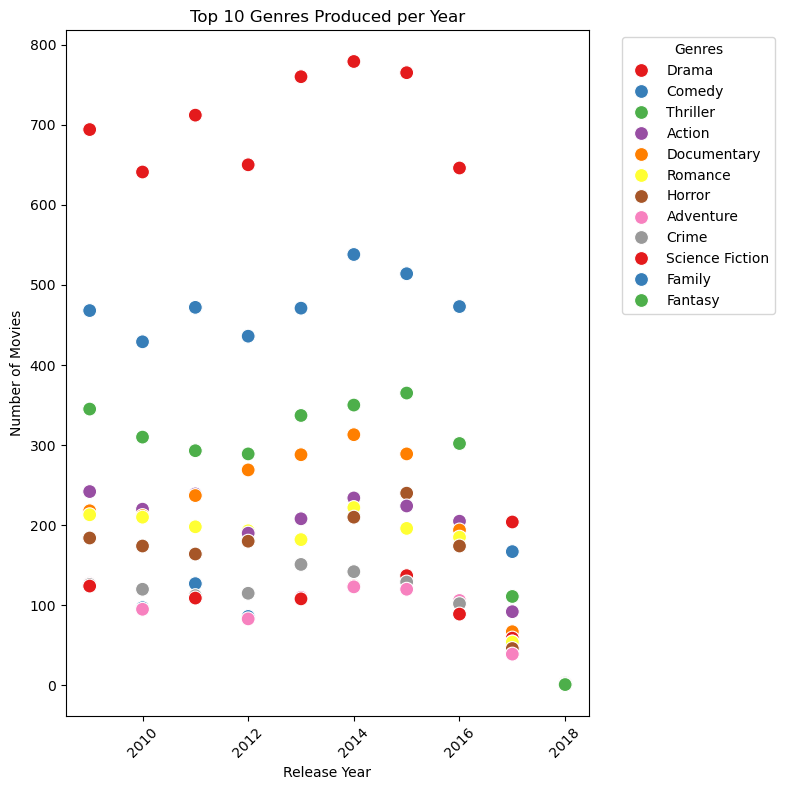

In [17]:
# Set the figure size
plt.figure(figsize=(8, 8))

# Create a scatter plot with Seaborn
sns.scatterplot(data=genre_explode, x="release_date", y="count", hue="genres", palette="Set1", s=100)

# Adding labels and title
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.title("Top 10 Genres Produced per Year")
plt.xticks(rotation=45)

# Display the legend
plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

In [18]:
# For each 'release_date', get the first (i.e., the genre with the lowest count)
lowest_genre_per_year = genre_explode.groupby("release_date").tail(1).reset_index(drop=True)

# Display the DataFrame
lowest_genre_per_year.head(10)


,release_date,genres,count
0,2009.0,Science Fiction,124
1,2010.0,Adventure,95
2,2011.0,Science Fiction,109
3,2012.0,Adventure,83
4,2013.0,Science Fiction,108
5,2014.0,Adventure,123
6,2015.0,Adventure,120
7,2016.0,Science Fiction,89
8,2017.0,Adventure,39
9,2018.0,Thriller,1


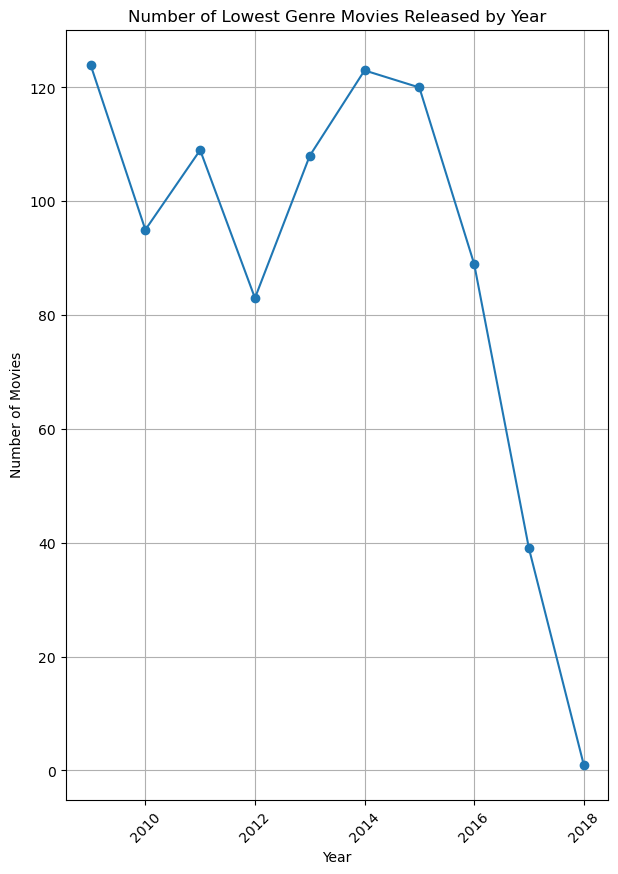

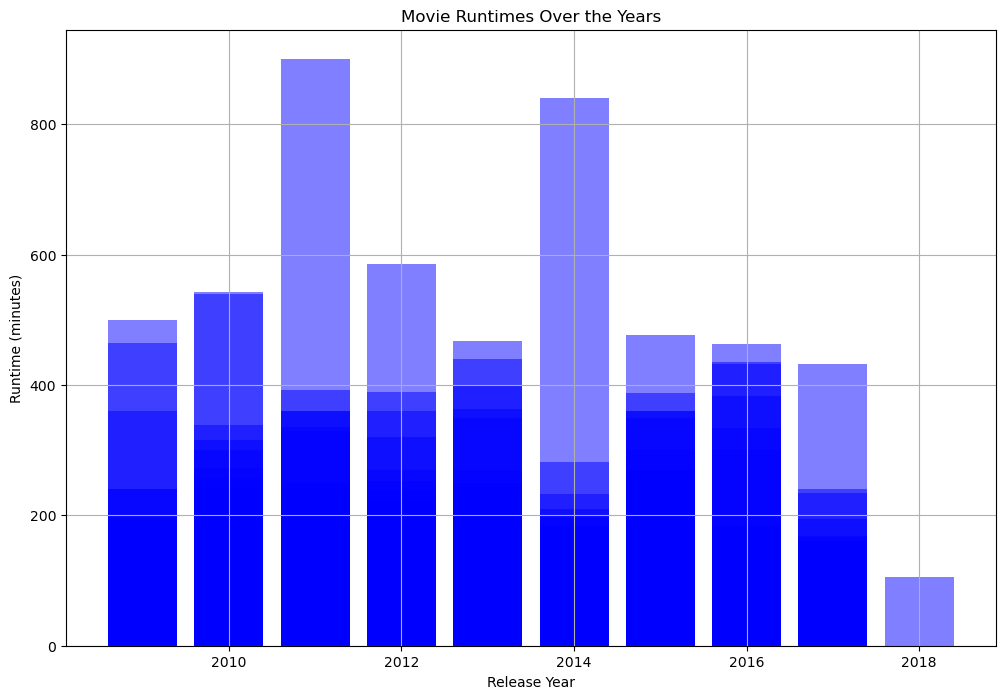

In [19]:
plt.figure(figsize=(7, 10))
plt.plot(lowest_genre_per_year["release_date"], lowest_genre_per_year["count"], marker='o')
plt.title("Number of Lowest Genre Movies Released by Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.grid()
plt.show()
#Question_3_your_name - What is the trend of movie runtimes over the years (e.g., are movies getting longer or shorter)?

trend_movies_df=last_decade_movies_df[["release_date","runtime"]]
trend_movies_df

# Set the figure size
plt.figure(figsize=(12, 8))
plt.bar(trend_movies_df["release_date"], trend_movies_df["runtime"], color="blue", alpha=0.5)
plt.title("Movie Runtimes Over the Years")
plt.xlabel("Release Year")
plt.ylabel("Runtime (minutes)")
# Set the limits for x and y axes to start and end at the range of data
#plt.xlim(highest_genre_per_year["release_date"].min() - 1, highest_genre_per_year["release_date"].max() + 1)  # Add a little padding
#plt.ylim(0, highest_genre_per_year["count"].max() + 10)  # Add a little padding above the highest count

plt.grid()
plt.show()


In [20]:
#Question_2_your_name - Which directors have the highest average IMDb ratings across their films?
#get the credits csv file
#Dropping Cast Column
clean_credits_df = credits_df.drop(columns = ["cast"])

#convert crew  from a list to rows
clean_credits_df["crew"]=clean_credits_df["crew"].apply(lambda x:ast.literal_eval(x) if isinstance(x, str) else x)

# Fill NaN with empty lists
clean_credits_df["crew"] = clean_credits_df["crew"].apply(lambda x: x if isinstance(x, list) else [])


clean_credits_df.head()


,crew,id
0,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [23]:
#extract the director from the crew column
def get_director(x):
    if isinstance(x,list):
        for i in x:
            if isinstance(i, dict)and i.get("job")=="Director":
                return i.get("name", "")
    return ""

#add director column to our original df
clean_credits_df["Director"]=clean_credits_df["crew"].apply(get_director)
#clean_credits_df.head()
# Check the results on a new dataframe to merge later
final_credits=clean_credits_df[["Director", "id"]]
final_credits.head()


,Director,id
0,John Lasseter,862
1,Joe Johnston,8844
2,Howard Deutch,15602
3,Forest Whitaker,31357
4,Charles Shyer,11862


In [24]:
#get data from our ratings.csv file
#rename movieId to id to merge dataframes

cleaned_rating_df = ratings_df.drop(columns=["userId", "timestamp"])
cleaned_rating_df.rename(columns={'movieId':"id"}, inplace=True)

cleaned_rating_df.head(10)


,id,rating
0,110,1.0
1,147,4.5
2,858,5.0
3,1221,5.0
4,1246,5.0
5,1968,4.0
6,2762,4.5
7,2918,5.0
8,2959,4.0
9,4226,4.0


In [25]:
final_movies['id'] = final_movies['id'].astype(int)

#merging director to movie ratings on id
merged_df=pd.merge(final_credits, cleaned_rating_df, on="id")
f_merged_df=pd.merge(merged_df, final_movies, on='id')
f_merged_df

first_rating_df = f_merged_df.drop_duplicates(subset=['Director', 'id'], keep='first')
first_rating_df_sorted = first_rating_df.sort_values(by='rating', ascending=False)

# Display the result
first_rating_df.head(15)


C:\Users\iffym\AppData\Local\Temp\ipykernel_2388\169079892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_movies['id'] = final_movies['id'].astype(int)


,Director,id,rating,original_title,vote_average,runtime
0,John Lasseter,862,3.0,Toy Story,7.7,81.0
374,Joe Johnston,8844,4.0,Jumanji,6.9,104.0
497,Michael Mann,949,4.0,Heat,7.7,170.0
2842,Martin Campbell,710,3.0,GoldenEye,6.6,130.0
4161,Renny Harlin,1408,5.0,Cutthroat Island,5.7,119.0
18049,Martin Scorsese,524,2.0,Casino,7.8,178.0
27212,Ang Lee,4584,4.0,Sense and Sensibility,7.2,136.0
27489,Allison Anders,5,3.0,Four Rooms,6.5,98.0
42747,Barry Sonnenfeld,8012,4.0,Get Shorty,6.4,105.0
43370,Jon Amiel,1710,3.0,Copycat,6.5,124.0


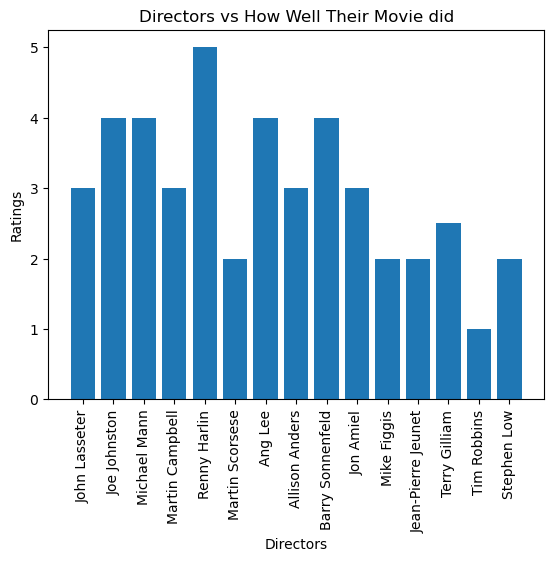

In [26]:
first_15_directors=first_rating_df.head(15)


plt.bar(first_15_directors["Director"], first_15_directors["rating"])
plt.xlabel("Directors")
plt.ylabel("Ratings")
plt.title("Directors vs How Well Their Movie did")
plt.xticks(rotation=90)
plt.tight_layout
plt.show()


In [27]:
#Final read data into CSV format
first_rating_df.to_csv('first_rating_directors.csv', index=False)
